# **MCMC - Simulated Stock Portolio**

Monte Carlo simulation is one of the most important quantitative methods available to financial analysts. They can be used to price derivatives on a risk-neutral metric or to simulate real-world dynamics to help understand portfolio returns and calculate relevant metrics regarding risk.

We will be assuming daily returns are distributed by a Multivariate Normal Distribution Rt∼MVN(μ,∑).

Cholesky Decomposition is used to determine Lower Triangular Matrix L∈LL′=∑.

Rt=μ+LZt

Zt∼N(0,I)
Where Zt are the samples from a normal distribution (Ι represents the Identity matrix).

In [5]:
import numpy as np
import scipy as sc
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import datetime as dt
from pandas_datareader import data as pdr
import yfinance as yfin

In [3]:
yfin.pdr_override()
# import data
def get_data(stocks, start, end):
    stockData = pdr.get_data_yahoo(stocks, start, end)
    stockData = stockData['Close']
    returns = stockData.pct_change()
    meanReturns = returns.mean()
    covMatrix = returns.cov()
    return meanReturns, covMatrix
stockList = ['CBA', 'BHP', 'TLS', 'NAB', 'WBC', 'STO']
stocks = [stock + '.AX' for stock in stockList]
endDate = dt.datetime.now()
startDate = endDate - dt.timedelta(days=300)
meanReturns, covMatrix = get_data(stocks, startDate, endDate)
weights = np.random.random(len(meanReturns))
weights /= np.sum(weights)

[*********************100%***********************]  6 of 6 completed


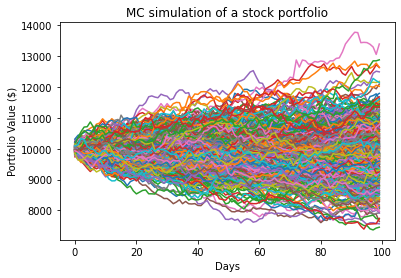

In [4]:
# Monte Carlo Method
mc_sims = 400 # number of simulations
T = 100 #timeframe in days
meanM = np.full(shape=(T, len(weights)), fill_value=meanReturns)
meanM = meanM.T
portfolio_sims = np.full(shape=(T, mc_sims), fill_value=0.0)
initialPortfolio = 10000
for m in range(0, mc_sims):
    Z = np.random.normal(size=(T, len(weights)))#uncorrelated RV's
    L = np.linalg.cholesky(covMatrix) #Cholesky decomposition to Lower Triangular Matrix
    dailyReturns = meanM + np.inner(L, Z) #Correlated daily returns for individual stocks
    portfolio_sims[:,m] = np.cumprod(np.inner(weights, dailyReturns.T)+1)*initialPortfolio
plt.plot(portfolio_sims)
plt.ylabel('Portfolio Value ($)')
plt.xlabel('Days')
plt.title('MC simulation of a stock portfolio')
plt.show()

# **Importance Sampling for OTM Options**

Recall that for Pricing a European Call Option under Risk-Neutral Pricing

E_Q[e^−(rT)(S_0e^(Z_T)–K)+], where Z_T∼N((r–σ^2)T,σ^2T)

We have a closed form solution with Black-Scholes.

In [6]:
def blackScholes(r, S, K, T, sigma, opt_type="c"):
    "Calculate BS price of call/put"
    d1 = (np.log(S/K) + (r + sigma**2/2)*T)/(sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    try:
        if opt_type == "c":
            price = S*sc.stats.norm.cdf(d1, 0, 1) - K*np.exp(-r*T)*sc.stats.norm.cdf(d2, 0, 1)
        elif opt_type == "p":
            price = K*np.exp(-r*T)*sc.stats.norm.cdf(-d2, 0, 1) - S*sc.stats.norm.cdf(-d1, 0, 1)
        return price
    except:
        print("Please confirm option type, either 'c' for Call or 'p' for Put!")
# Initialise parameters
S0 = 100.0     # initial stock price
K = 170.0      # strike price
T = 1.0        # time to maturity in years
r = 0.06       # annual risk-free rate
vol = 0.20     # volatility (%)
dt = T
nudt = (r - 0.5*vol**2)*dt
nudt2 = (np.log(K/S0)-0.5*vol**2)*dt
volsdt = vol*np.sqrt(dt)
BS = blackScholes(r, S0, K, T, vol)
print("Black Scholes Price: ", round(BS,4))

Black Scholes Price:  0.0789


# **Benefits of Importance Sampling?**

E[f(x)]=∫f(x)p(x)dx≈1n∑if(xi)

Example: Just How Unlucky is a 25 Standard Deviation Loss?

http://www.columbia.edu/~mh2078/MonteCarlo/MCS_AdvVarRed_MasterSlides.pdf

θ=P(X≥25)=E[I(X≥25)] when X∼N(0,1)

In [7]:
M = 1000000
Z = np.random.normal(0,1, M) 
# Indicator function, count number of sampled variables above 25
ZT = np.where(Z>25,1,0)
X = np.mean( ZT )
# Calculate standard error and 95% Condifence intervals
sigma = np.std(ZT)
SE = sigma/np.sqrt(M)
CIs = [X-SE*1.96,X+SE*1.96]
print('95% Confidence Levels for 25 St Dev. Returns are [{:0.3e}, {:0.3e}]'.format(CIs[0], CIs[1]))

95% Confidence Levels for 25 St Dev. Returns are [0.000e+00, 0.000e+00]


Method of Importance Sampling – change of distribution

E[f(x)]=∫f(x)p(x)dx=∫f(x)p(x)q(x)q(x)dx≈1n∑if(xi)p(x)q(x)

For the Normal Distribution (and many other distributions), we can work out an analytical form for the distribution PDF ratio p(x)/q(x).

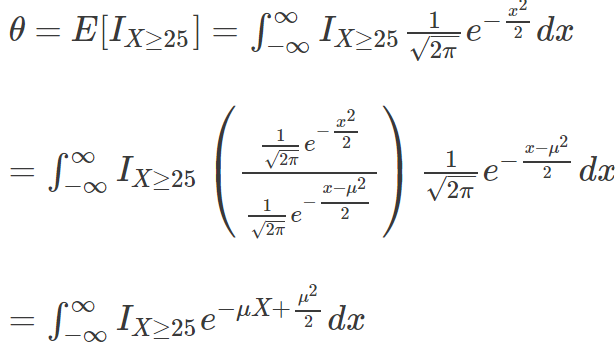

In [8]:
M = 1000
mu=25
Z = np.random.normal(mu,1, M) 
# Method 1 - use scipy stats PDF functions
p = sc.stats.norm(0, 1)
q = sc.stats.norm(mu, 1)
ZT = np.where(Z>25,1,0)*p.pdf(Z)/q.pdf(Z)
# Method 2 - direct with analytical ratio
ZT = np.where(Z>25,1,0)*np.exp(-mu*Z + mu**2/2)
X = np.mean( ZT )
sigma = np.std(ZT)
SE = sigma/np.sqrt(M)
CIs = [X-SE*1.96,X+SE*1.96]
print('95% Confidence Levels for 25 St Dev. Returns are [{:0.3e}, {:0.3e}]'.format(CIs[0], CIs[1]))

95% Confidence Levels for 25 St Dev. Returns are [3.152e-138, 5.837e-138]


# **Importance Sampling and Radon-Nikodym derivative**



Importance Sampling: E[f(x)]=∫f(x)p(x)dx=∫f(x)p(x)q(x)q(x)dx≈1n∑if(xi)p(x)q(x)

Radon-Nikodym derivative: EQ[f(ST)]=EQ0[f(ST)dQdQ0]

There exists a change of measure called the Radon-Nikodym derivative: dQ/dQ0
So conduct a simulation under a new measure Q0 and then  multiply by the ratio of the two probability density functions, or the Radon Nikodym derivative of one process with respect to the other. 

Note: For more complicated processes and derivatives one needs to use the densities given by Girsanovs Theorem within the monte carlo simulation.

**Using a Far OTM Put Option to demonstrate the power of Importance Sampling**
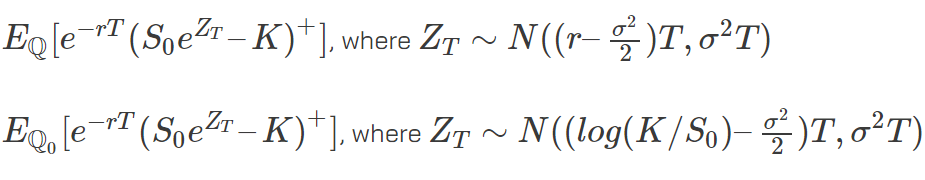

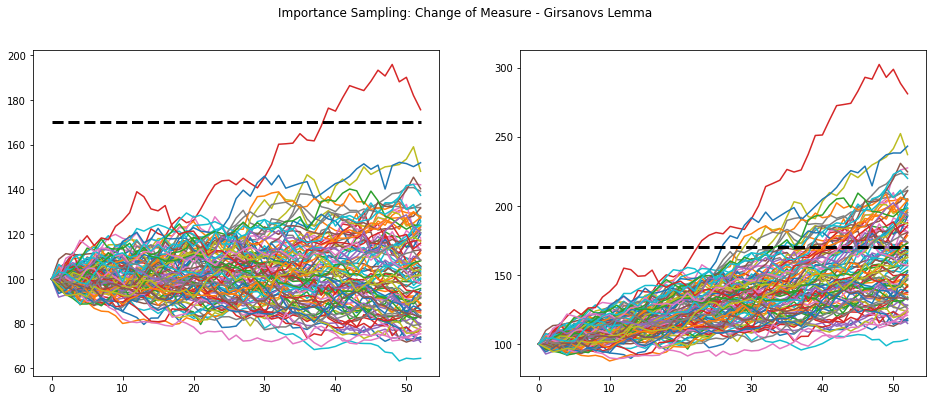

In [9]:
M = 100
N = 52
#precompute constants
dt = T/N
nudt = (r - 0.5*vol**2)*dt
nudt2 = (np.log(K/S0)-0.5*vol**2)*dt
volsdt = vol*np.sqrt(dt)
lnS = np.log(S0)
# Monte Carlo Method
Z = np.random.normal(0,1,size=(N, M)) 
delta_lnSt = nudt + volsdt*Z 
lnSt = lnS + np.cumsum(delta_lnSt, axis=0)
lnSt = np.concatenate( (np.full(shape=(1, M), fill_value=lnS), lnSt ) )
delta_lnSt2 = nudt2 + volsdt*Z 
lnSt2 = lnS + np.cumsum(delta_lnSt2, axis=0)
lnSt2 = np.concatenate( (np.full(shape=(1, M), fill_value=lnS), lnSt2 ) )
ST = np.exp(lnSt)
ST2 = np.exp(lnSt2)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,6))
fig.suptitle('Importance Sampling: Change of Measure - Girsanovs Lemma')
ax1.plot(ST)
ax1.plot([0,N],[K,K],'k--',linewidth=3)
ax2.plot(ST2)
ax2.plot([0,N],[K,K],'k--',linewidth=3)
plt.show()

In [10]:
# Initialise parameters
S0 = 100.0     # initial stock price
K = 170.0      # strike price
T = 1.0        # time to maturity in years
r = 0.06       # annual risk-free rate
vol = 0.20     # volatility (%)
dt = T
nudt = (r - 0.5*vol**2)*dt
nudt2 = (np.log(K/S0)-0.5*vol**2)*dt
volsdt = vol*np.sqrt(dt)
nudt, nudt2

(0.039999999999999994, 0.5106282510621704)

**Choosing the correct distribution to minimize variance**
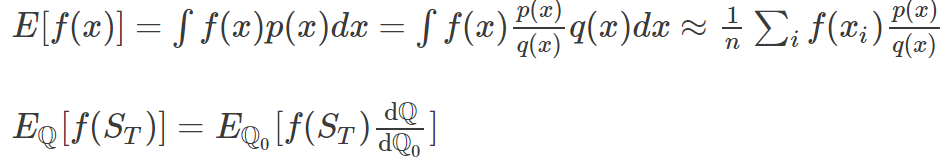

Unfortunately there is no general way to final the optimal q(x) distribution under dQ0 distribution. But we can find the relatively optimal g to reduce variance.
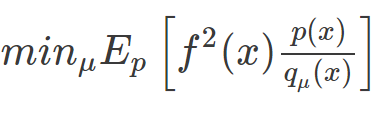

In [11]:
p = sc.stats.norm(nudt,volsdt)
q = lambda mu: sc.stats.norm(mu, volsdt)
z_T = lambda x, mu, sig: mu + sig*x
f_0 = lambda z: np.exp(-r*T)*np.maximum(0, S0*np.exp(z)-K)
M = 1000000
def arg_min(x):
    x_T = np.random.normal(0, 1, M)
    z = z_T(x_T,nudt,volsdt)
    return np.mean( f_0(z)**2 * p.pdf(z)/q(x).pdf(z) )
mu_star = sc.optimize.fmin(lambda x: arg_min(x), nudt2, disp=True)
mu_star
C0_is, SE_is = [], []
for M in np.arange(100,1000+100,100):
    mu = mu_star[0]
    x = np.random.randn(M)
    z = z_T(x,mu,volsdt)
    CT = f_0(z) * p.pdf(z)/q(mu).pdf(z)
    C0 = np.mean( CT )
    sigma = np.sqrt( np.sum( (CT - C0)**2) / (M-1) )
    SE = sigma/np.sqrt(M)
    
    C0_is.append(C0)
    SE_is.append(SE)
    
C0_is = np.array(C0_is)
SE_is = np.array(SE_is)
print("Call value is ${0} with SE +/- {1}".format(np.round(C0_is,3),np.round(SE_is,3)))
C0_wo, SE_wo = [], []
for M in np.arange(100,1000+100,100):
    x = np.random.randn(M)
    z = z_T(x, nudt, volsdt)
    CT = f_0(z)
    C0 = np.mean( CT )
    sigma = np.sqrt( np.sum( (CT - C0)**2) / (M-1) )
    SE = sigma/np.sqrt(M)
    C0_wo.append(C0)
    SE_wo.append(SE)
    
C0_wo = np.array(C0_wo)
SE_wo = np.array(SE_wo)
print("Call value is ${0} with SE +/- {1}".format(np.round(C0_wo,3),np.round(SE_wo,3)))
SE_Ratio = SE_wo/SE_is
print("Standard Error Reduction Factor {0}".format(np.round(SE_Ratio,3)))
import pandas as pd
M = np.arange(100,1000+100,100)
prices = pd.DataFrame(np.array([M, C0_wo.round(3), C0_is.round(3), SE_wo.round(3), SE_is.round(3), SE_Ratio.round(1)]).T, 
                      columns=['Simulations','Price_wo', 'Price_is','SE_wo', 'SE_is', 'Reduction'])
print("Black Scholes Price: ", round(BS,4))
prices

Optimization terminated successfully.
         Current function value: 0.012792
         Iterations: 16
         Function evaluations: 39
Call value is $[0.087 0.084 0.083 0.079 0.082 0.075 0.077 0.078 0.074 0.08 ] with SE +/- [0.009 0.006 0.005 0.004 0.004 0.003 0.003 0.003 0.003 0.003]
Call value is $[0.119 0.05  0.072 0.    0.05  0.172 0.035 0.051 0.135 0.053] with SE +/- [0.119 0.049 0.051 0.    0.037 0.088 0.022 0.029 0.054 0.033]
Standard Error Reduction Factor [13.528  8.054 10.332  0.    10.052 26.387  7.081 10.004 19.925 12.285]
Black Scholes Price:  0.0789


,Simulations,Price_wo,Price_is,SE_wo,SE_is,Reduction
0,100.0,0.119,0.087,0.119,0.009,13.5
1,200.0,0.050,0.084,0.049,0.006,8.1
2,300.0,0.072,0.083,0.051,0.005,10.3
3,400.0,0.000,0.079,0.000,0.004,0.0
4,500.0,0.050,0.082,0.037,0.004,10.1
5,600.0,0.172,0.075,0.088,0.003,26.4
6,700.0,0.035,0.077,0.022,0.003,7.1
7,800.0,0.051,0.078,0.029,0.003,10.0
8,900.0,0.135,0.074,0.054,0.003,19.9
9,1000.0,0.053,0.080,0.033,0.003,12.3
